## Multi-Objective BO with Decoupled Evaluations using HVKG
In this tutorial, we illustrate how to use the hypervolume knowledge gradient for problems where the objectives can be evaluated independently (decoupled). 

There are two types of decoupling:

* **Competitive decoupling**: where the objectives are evaluated using the same evaluation resource. Often the objectives have heterogenous costs and therefore it is prudent to select what design and objective to evaluate in a cost-aware fashion.

* **Non-competitive decoupling**: where the objectives have independent evaluation resources and potentially different numbers of designs can be evaluated in parallel. In this scenario, all available evaluation resources should be exploited and the goal is to optimize the objectives as well as possible within a fixed number of time steps.

In this tutorial, we focus on competitive decoupling and show how HVKG can be used for efficient optimization.

[1] [S. Daulton, M. Balandat, and E. Bakshy. Hypervolume Knowledge Gradient: A Lookahead Approach for Multi-Objective Bayesian Optimization with Partial Information. ICML, 2023.](https://proceedings.mlr.press/v202/daulton23a.html)

Note: `pymoo` is an optional dependency that is used for determining the Pareto set of optimal designs under the model posterior mean using NSGA-II (which is not a sample efficient method, but sample efficiency is not critical for this step). If `pymoo` is not available, the Pareto set of optimal designs is selected from a discrete set. This will work okay for low-dim (e.g. $\leq2$ dimensions) problems, but in general NSGA-II will yield far better results.

### Set dtype and device
Note: HVKG aggressively exploits parallel hardware and is much faster when run on a GPU.

In [ ]:
# Install dependencies if we are running in colab
import sys
if 'google.colab' in sys.modules:
    %pip install botorch

In [1]:
import os

import torch


tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST")

I1110 064940.229 _utils_internal.py:230] NCCL_DEBUG env var is set to None


I1110 064940.231 _utils_internal.py:239] NCCL_DEBUG is INFO from /etc/nccl.conf


### Problem setup

In this tutorial, we optimize a bi-objective synthetic function ZDT2 over a 6-dimensional space. The costs of evaluating each objective are 3 and 1, respectively, which we choose to be different to reflect that many multi-objective optimization problems have heterogeneous costs.

In [2]:
from botorch.test_functions.multi_objective import ZDT2
from botorch.models.cost import FixedCostModel


problem = ZDT2(negate=True, dim=6).to(**tkwargs)

# define the cost model
objective_costs = {0: 3.0, 1: 1.0}
objective_indices = list(objective_costs.keys())
objective_costs = {int(k): v for k, v in objective_costs.items()}
objective_costs_t = torch.tensor(
    [objective_costs[k] for k in sorted(objective_costs.keys())], **tkwargs
)
cost_model = FixedCostModel(fixed_cost=objective_costs_t)

#### Model initialization

We use a list of `SingleTaskGP`s to model the two objectives with known noise variances. The models are initialized with $2(d+1)=14$ points drawn randomly from $[0,1]^2$. Since the objectives can be evaluated independently, the number of observations of each objective can be different. Therefore, we must use a `ModelListGP`.

In [3]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import normalize, unnormalize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from torch import Tensor
from gpytorch.priors import GammaPrior
from gpytorch.kernels import MaternKernel, ScaleKernel


def generate_initial_data(n):
    # generate training data
    train_x = draw_sobol_samples(bounds=problem.bounds, n=n, q=1).squeeze(1)
    train_obj_true = problem(train_x)
    return train_x, train_obj_true


def initialize_model(train_x_list, train_obj_list):
    # define models for objective and constraint
    train_x_list = [normalize(train_x, problem.bounds) for train_x in train_x_list]
    models = []
    for i in range(len(train_obj_list)):
        train_y = train_obj_list[i]
        train_yvar = torch.full_like(train_y, 1e-7)  # noiseless
        models.append(
            SingleTaskGP(
                train_X=train_x_list[i],
                train_Y=train_y,
                train_Yvar=train_yvar,
                outcome_transform=Standardize(m=1),
                covar_module=ScaleKernel(
                    MaternKernel(
                        nu=2.5,
                        ard_num_dims=train_x_list[0].shape[-1],
                        lengthscale_prior=GammaPrior(2.0, 2.0),
                    ),
                    outputscale_prior=GammaPrior(2.0, 0.15),
                )
            )
        )
    model = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper functions that performs the essential BO step for $q$NEHVI and HVKG
The helper function below initializes the $q$NEHVI acquisition function (a strong baseline, but one that does not support decoupled evaluations), optimizes it, and returns the candidate along with the observed function values. 

**Reference Point**

$q$NEHVI and HVKG require specifying a reference point, which is the lower bound on the objectives used for computing hypervolume. In this tutorial, we assume the reference point is known. In practice the reference point can be set 1) using domain knowledge to be slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective, or 2) using a dynamic reference point selection strategy.

In [4]:
from botorch.acquisition.multi_objective.monte_carlo import (
    qNoisyExpectedHypervolumeImprovement,
)
from botorch.optim.optimize import optimize_acqf


BATCH_SIZE = 1
NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4

standard_bounds = torch.zeros(2, problem.dim, **tkwargs)
standard_bounds[1] = 1


def optimize_qnehvi_and_get_observation(model, train_x, sampler):
    """Optimizes the qNEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    acq_func = qNoisyExpectedHypervolumeImprovement(
        model=model,
        ref_point=problem.ref_point.tolist(),  # use known reference point
        X_baseline=normalize(train_x, problem.bounds),
        prune_baseline=True,  # prune baseline points that have estimated zero probability of being Pareto optimal
        sampler=sampler,
    )
    # optimize
    candidates, _ = optimize_acqf(
        acq_function=acq_func,
        bounds=standard_bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
        sequential=True,
    )
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj_true = problem(new_x)
    return new_x, new_obj_true

### Helper Function for initializing and optimizing HVKG

Below we define the following helper functions:
1. `get_current_value` for computing the current hypervolume of the hypervolume maximizing set under the posterior mean.
2. `optimize_HVKG_and_get_obs_decoupled` to initialize and optimize HVKG to determine which design to evaluate and which objective to evaluate the design on. This method obtains the observation corresponding to that design.

In [5]:
from botorch.acquisition.cost_aware import InverseCostWeightedUtility
from botorch.acquisition.multi_objective.hypervolume_knowledge_gradient import (
    _get_hv_value_function,
    qHypervolumeKnowledgeGradient,
)
from botorch.models.deterministic import GenericDeterministicModel
from botorch.sampling.list_sampler import ListSampler
from botorch.sampling.normal import IIDNormalSampler

NUM_PARETO = 2 if SMOKE_TEST else 10
NUM_FANTASIES = 2 if SMOKE_TEST else 8
NUM_HVKG_RESTARTS = 1


def get_current_value(
    model,
    ref_point,
    bounds,
):
    """Helper to get the hypervolume of the current hypervolume
    maximizing set.
    """
    curr_val_acqf = _get_hv_value_function(
        model=model,
        ref_point=ref_point,
        use_posterior_mean=True,
    )
    _, current_value = optimize_acqf(
        acq_function=curr_val_acqf,
        bounds=bounds,
        q=NUM_PARETO,
        num_restarts=20,
        raw_samples=1024,
        return_best_only=True,
        options={"batch_limit": 5},
    )
    return current_value


def optimize_HVKG_and_get_obs_decoupled(model):
    """Utility to initialize and optimize HVKG."""
    cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

    current_value = get_current_value(
        model=model,
        ref_point=problem.ref_point,
        bounds=standard_bounds,
    )

    acq_func = qHypervolumeKnowledgeGradient(
        model=model,
        ref_point=problem.ref_point,  # use known reference point
        num_fantasies=NUM_FANTASIES,
        num_pareto=NUM_PARETO,
        current_value=current_value,
        cost_aware_utility=cost_aware_utility,
    )

    # optimize acquisition functions and get new observations
    objective_vals = []
    objective_candidates = []
    for objective_idx in objective_indices:
        # set evaluation index to only condition on one objective
        # this could be multiple objectives
        X_evaluation_mask = torch.zeros(
            1,
            len(objective_indices),
            dtype=torch.bool,
            device=standard_bounds.device,
        )
        X_evaluation_mask[0, objective_idx] = 1
        acq_func.X_evaluation_mask = X_evaluation_mask
        candidates, vals = optimize_acqf(
            acq_function=acq_func,
            num_restarts=NUM_HVKG_RESTARTS,
            raw_samples=RAW_SAMPLES,
            bounds=standard_bounds,
            q=BATCH_SIZE,
            sequential=False,
            options={"batch_limit": 5},
        )
        objective_vals.append(vals.view(-1))
        objective_candidates.append(candidates)
    best_objective_index = torch.cat(objective_vals, dim=-1).argmax().item()
    eval_objective_indices = [best_objective_index]
    candidates = objective_candidates[best_objective_index]
    vals = objective_vals[best_objective_index]
    # observe new values
    new_x = unnormalize(candidates.detach(), bounds=problem.bounds)
    new_obj = problem(new_x)
    new_obj = new_obj[..., eval_objective_indices]
    return new_x, new_obj, eval_objective_indices

## Define function to find model-estimated Pareto set of designs under posterior mean using NSGA-II


In [6]:
import numpy as np
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)
from botorch.utils.multi_objective.pareto import _is_non_dominated_loop
from gpytorch import settings

try:
    from pymoo.algorithms.nsga2 import NSGA2
    from pymoo.model.problem import Problem
    from pymoo.optimize import minimize
    from pymoo.util.termination.max_gen import MaximumGenerationTermination

    def get_model_identified_hv_maximizing_set(
        model,
        population_size=250,
        max_gen=100,
    ):
        """Optimize the posterior mean using NSGA-II."""
        tkwargs = {
            "dtype": problem.ref_point.dtype,
            "device": problem.ref_point.device,
        }
        dim = problem.dim

        class PosteriorMeanPymooProblem(Problem):
            def __init__(self):
                super().__init__(
                    n_var=dim,
                    n_obj=problem.num_objectives,
                    type_var=np.double,
                )
                self.xl = np.zeros(dim)
                self.xu = np.ones(dim)

            def _evaluate(self, x, out, *args, **kwargs):
                X = torch.from_numpy(x).to(**tkwargs)
                is_fantasy_model = (
                    isinstance(model, ModelListGP)
                    and model.models[0].train_targets.ndim > 2
                ) or (
                    not isinstance(model, ModelListGP) and model.train_targets.ndim > 2
                )
                with torch.no_grad():
                    with settings.cholesky_max_tries(9):
                        # eval in batch mode
                        y = model.posterior(X.unsqueeze(-2)).mean.squeeze(-2)
                    if is_fantasy_model:
                        y = y.mean(dim=-2)
                out["F"] = -y.cpu().numpy()

        pymoo_problem = PosteriorMeanPymooProblem()
        algorithm = NSGA2(
            pop_size=population_size,
            eliminate_duplicates=True,
        )
        res = minimize(
            pymoo_problem,
            algorithm,
            termination=MaximumGenerationTermination(max_gen),
            # seed=0,  # fix seed
            verbose=False,
        )
        X = torch.tensor(
            res.X,
            **tkwargs,
        )
        X = unnormalize(X, problem.bounds)
        Y = problem(X)
        # compute HV
        partitioning = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=Y)
        return partitioning.compute_hypervolume().item()

except ImportError:
    NUM_DISCRETE_POINTS = 100 if SMOKE_TEST else 100000
    CHUNK_SIZE = 512

    def get_model_identified_hv_maximizing_set(
        model,
    ):
        """Optimize the posterior mean over a discrete set."""
        tkwargs = {
            "dtype": problem.ref_point.dtype,
            "device": problem.ref_point.device,
        }
        dim = problem.dim

        discrete_set = torch.rand(NUM_DISCRETE_POINTS, dim, **tkwargs)
        with torch.no_grad():
            preds_list = []
            for start in range(0, NUM_DISCRETE_POINTS, CHUNK_SIZE):
                preds = model.posterior(
                    discrete_set[start : start + CHUNK_SIZE].unsqueeze(-2)
                ).mean.squeeze(-2)
                preds_list.append(preds)
            preds = torch.cat(preds_list, dim=0)
            pareto_mask = _is_non_dominated_loop(preds)
            pareto_X = discrete_set[pareto_mask]
        pareto_X = unnormalize(pareto_X, problem.bounds)
        Y = problem(pareto_X)
        # compute HV
        partitioning = FastNondominatedPartitioning(ref_point=problem.ref_point, Y=Y)
        return partitioning.compute_hypervolume().item()

### Perform Bayesian Optimization loop with Decoupled HVKG and compared against non-decoupled $q$NEHVI
The Bayesian optimization "loop" for a batch size of 1 simply iterates the following steps:
1. given a surrogate model, choose a candidate design *and* objective to evaluate (for methods that leverage decoupled evaluations).
2. observe one or more objectives for the candidate design.
3. update the surrogate model.

The loop will continue to run until a pre-specified evaluation budget (in terms of cost) is exhausted.

In [7]:
import time
import warnings

from botorch import fit_gpytorch_mll
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.sampling.normal import SobolQMCNormalSampler


warnings.filterwarnings("ignore", category=BadInitialCandidatesWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

MC_SAMPLES = 128 if not SMOKE_TEST else 16
COST_BUDGET = 90 if not SMOKE_TEST else 54
torch.manual_seed(0)
verbose = True
N_INIT = 2 * problem.dim + 1

total_cost = {"hvkg": 0.0, "qnehvi": 0.0, "random": 0.0}


# call helper functions to generate initial training data and initialize model
train_x_hvkg, train_obj_hvkg = generate_initial_data(n=N_INIT)
train_obj_hvkg_list = list(train_obj_hvkg.split(1, dim=-1))
train_x_hvkg_list = [train_x_hvkg] * len(train_obj_hvkg_list)
mll_hvkg, model_hvkg = initialize_model(train_x_hvkg_list, train_obj_hvkg_list)
train_obj_random_list = train_obj_hvkg_list
train_x_random_list = train_x_hvkg_list
train_x_qnehvi_list, train_obj_qnehvi_list = (
    train_x_hvkg_list,
    train_obj_hvkg_list,
)
cost_hvkg = cost_model(train_x_hvkg).sum(dim=-1)
total_cost["hvkg"] += cost_hvkg.sum().item()
cost_qnehvi = cost_hvkg
cost_random = cost_hvkg
total_cost["qnehvi"] = total_cost["hvkg"]
total_cost["random"] = total_cost["hvkg"]
mll_qnehvi, model_qnehvi = initialize_model(train_x_qnehvi_list, train_obj_qnehvi_list)
mll_random, model_random = initialize_model(train_x_random_list, train_obj_random_list)
# fit the models
fit_gpytorch_mll(mll_hvkg)
fit_gpytorch_mll(mll_qnehvi)
fit_gpytorch_mll(mll_random)
# compute hypervolume
hv = get_model_identified_hv_maximizing_set(model=model_qnehvi)
hvs_hvkg, hvs_qehvi, hvs_qnehvi, hvs_random = [hv], [hv], [hv], [hv]
if verbose:
    print(
        f"\nInitial: Hypervolume (random, qHVKG, qNEHVI) = "
        f"({hvs_random[-1]:>4.2f}, {hvs_hvkg[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}).",
        end="",
    )
# run N_BATCH rounds of BayesOpt after the initial random batch
iteration = 0
active_algos = {k for k, v in total_cost.items() if v < COST_BUDGET}
while any(v < COST_BUDGET for v in total_cost.values()):

    t0 = time.monotonic()
    if "hvkg" in active_algos:
        # generate candidates
        (
            new_x_hvkg,
            new_obj_hvkg,
            eval_objective_indices_hvkg,
        ) = optimize_HVKG_and_get_obs_decoupled(
            model_hvkg,
        )
        # update training points
        for i in eval_objective_indices_hvkg:
            train_x_hvkg_list[i] = torch.cat([train_x_hvkg_list[i], new_x_hvkg])
            train_obj_hvkg_list[i] = torch.cat(
                [train_obj_hvkg_list[i], new_obj_hvkg], dim=0
            )
        # update costs
        all_outcome_cost = cost_model(new_x_hvkg)
        new_cost_hvkg = all_outcome_cost[..., eval_objective_indices_hvkg].sum(dim=-1)
        cost_hvkg = torch.cat([cost_hvkg, new_cost_hvkg], dim=0)
        total_cost["hvkg"] += new_cost_hvkg.sum().item()
        # fit models
        mll_hvkg, model_hvkg = initialize_model(train_x_hvkg_list, train_obj_hvkg_list)
        fit_gpytorch_mll(mll_hvkg)

    if "qnehvi" in active_algos:
        qnehvi_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([MC_SAMPLES]))
        # generate candidates
        new_x_qnehvi, new_obj_qnehvi = optimize_qnehvi_and_get_observation(
            model_qnehvi, train_x_qnehvi_list[0], qnehvi_sampler
        )
        # update training points
        for i in objective_indices:
            train_x_qnehvi_list[i] = torch.cat([train_x_qnehvi_list[i], new_x_qnehvi])
            train_obj_qnehvi_list[i] = torch.cat(
                [train_obj_qnehvi_list[i], new_obj_qnehvi[..., i : i + 1]]
            )
        # update costs
        new_cost_qnehvi = cost_model(new_x_qnehvi).sum(dim=-1)
        cost_qnehvi = torch.cat([cost_qnehvi, new_cost_qnehvi], dim=0)
        total_cost["qnehvi"] += new_cost_qnehvi.sum().item()
        # fit models
        mll_qnehvi, model_qnehvi = initialize_model(
            train_x_qnehvi_list, train_obj_qnehvi_list
        )
        fit_gpytorch_mll(mll_qnehvi)
    if "random" in active_algos:
        # generate candidates
        new_x_random, new_obj_random = generate_initial_data(n=BATCH_SIZE)
        # update training points
        for i in objective_indices:
            train_x_random_list[i] = torch.cat([train_x_random_list[i], new_x_random])
            train_obj_random_list[i] = torch.cat(
                [train_obj_random_list[i], new_obj_random[..., i : i + 1]]
            )
        # update costs
        new_cost_random = cost_model(new_x_random).sum(dim=-1)
        cost_random = torch.cat([cost_random, new_cost_random], dim=0)
        total_cost["random"] += new_cost_random.sum().item()
        # fit models
        mll_random, model_random = initialize_model(
            train_x_random_list, train_obj_random_list
        )
        fit_gpytorch_mll(mll_random)

    # compute hypervolume
    for label, model, hv_list in zip(
        ["hvkg", "qnehvi", "random"],
        [model_hvkg, model_qnehvi, model_random],
        [hvs_hvkg, hvs_qnehvi, hvs_random],
    ):
        if label in active_algos:
            hv = get_model_identified_hv_maximizing_set(model=model)
            hv_list.append(hv)
        else:
            # no update performed
            hv_list.append(hv_list[-1])

    t1 = time.monotonic()
    if verbose:
        print(
            f"\nBatch {iteration:>2}: Costs (random, qHVKG, qNEHVI) = "
            f"({total_cost['random']:>4.2f}, {total_cost['hvkg']:>4.2f}, {total_cost['qnehvi']:>4.2f}). "
        )
        print(
            f"\nHypervolume (random, qHVKG, qNEHVI) = "
            f"({hvs_random[-1]:>4.2f}, {hvs_hvkg[-1]:>4.2f}, {hvs_qnehvi[-1]:>4.2f}), "
            f"time = {t1-t0:>4.2f}.",
            end="",
        )
    else:
        print(".", end="")
    iteration += 1
    active_algos = {k for k, v in total_cost.items() if v < COST_BUDGET}


Initial: Hypervolume (random, qHVKG, qNEHVI) = (89.34, 89.34, 89.34).

#### Plot the cost vs inference regret
The plot below shows the a common metric of multi-objective optimization performance, the log hypervolume difference: the log difference between the hypervolume of the true pareto front and the hypervolume of the inferred pareto set of designs identified by each algorithm. The log hypervolume difference is plotted cover cost. This is also known as inference regret.

The plot shows that HVKG identifies the Pareto optimal designs much faster than $q$NEHVI, and Sobol.

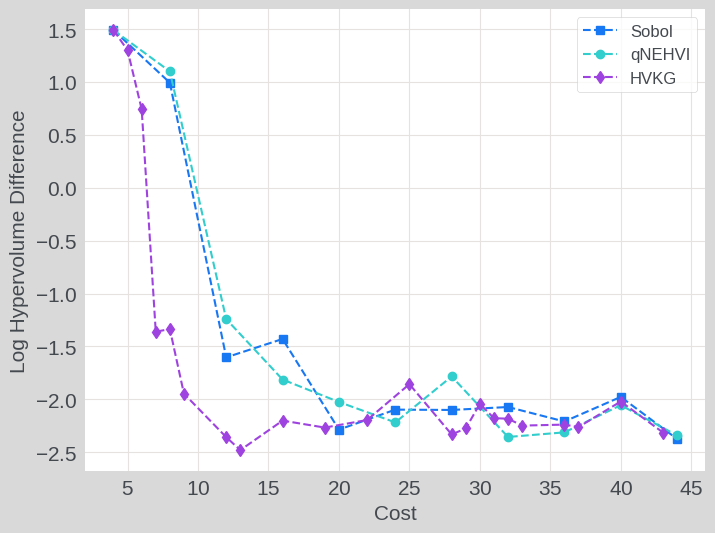

In [21]:
from matplotlib import pyplot as plt

%matplotlib inline


log_hv_difference_hvkg = np.log10(problem.max_hv - np.asarray(hvs_hvkg))
log_hv_difference_qnehvi = np.log10(problem.max_hv - np.asarray(hvs_qnehvi))
log_hv_difference_rnd = np.log10(problem.max_hv - np.asarray(hvs_random))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
running_cost_random = np.cumsum(cost_random.cpu().numpy()[N_INIT-1:])
running_cost_qnehvi = np.cumsum(cost_qnehvi.cpu().numpy()[N_INIT-1:])
running_cost_hvkg = np.cumsum(cost_hvkg.cpu().numpy()[N_INIT-1:])
ax.errorbar(
    running_cost_random,
    log_hv_difference_rnd[: len(running_cost_random)],
    label="Sobol",
    linewidth=1.5,
    ls="--",
    marker="s",
)
ax.errorbar(
    running_cost_qnehvi,
    log_hv_difference_qnehvi[: len(running_cost_qnehvi)],
    label="qNEHVI",
    linewidth=1.5,
    ls="--",
    marker="o"
)
ax.errorbar(
    running_cost_hvkg,
    log_hv_difference_hvkg[: len(running_cost_hvkg)],
    label="HVKG",
    linewidth=1.5,
    ls="--",
    marker="d"
)
ax.set(
    xlabel="Cost",
    ylabel="Log Hypervolume Difference",
)
ax.legend(loc="upper right")